In [276]:
import pandas as pd
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
# from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta

In [277]:
df = pd.read_csv("../data/csv/Gold_Data.csv",index_col="Business_Week")
print(len(df.columns),len(df.index))

22 684


In [278]:
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[7],axis=1)
df = df.dropna(axis=1)
df = df.dropna()
print(len(df.columns),len(df.index))

16 684


In [279]:
df.iloc[25:30]

,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Date,Open Interest,Money Manager Shorts,Money Manager Longs,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Business_Week,,,,,,,,,,,,,,,,
"[2006-11-29, 2006-12-05]",642.920,6588.40,177474.80,2006-12-05,415169.0,28109.0,83017.0,109.190625,503803.40,2290807.00,-0.710,82.6880,4183.80,39907.80,-0.0515,7.170700
"[2006-12-06, 2006-12-12]",629.100,271.20,199309.80,2006-12-12,411990.0,28486.0,80167.0,108.896875,44313.60,2245432.80,0.560,82.9700,6064.40,45323.20,-0.0995,7.056700
"[2006-12-13, 2006-12-19]",621.020,67.80,196572.40,2006-12-19,416337.0,29269.0,69911.0,108.346875,14641.80,2256095.00,1.238,83.9032,1960.00,43780.00,0.0095,6.990900
"[2006-12-20, 2006-12-26]",620.400,146.75,195192.25,2006-12-26,415984.0,32791.0,71209.0,108.367188,484666.25,2187903.25,0.570,83.7370,653.75,23270.00,0.0480,7.072333
"[2006-12-27, 2007-01-02]",655.675,14759.25,289355.00,2007-01-03,434040.0,31903.0,79570.0,107.632812,393302.50,2200475.75,-0.850,83.4125,2102.50,28215.25,-0.1650,7.059125


In [280]:
# Freq is very important, specifies when and how often data is taken.
# VAR will not work without.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df["Date"])):
    if df["Date"][i].weekday() != 1:
        print(df["Date"][i])
        try:
            df.at[i,"Date"] = df["Date"][i-1]+timedelta(days=7)
#             print(df["Date"][i])
#             print(df["Date"][i].weekday())
        except:
            df.at[i,"Date"] = df["Date"][i+1]-timedelta(days=7)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")

2006-07-03 00:00:00
2007-01-03 00:00:00
2007-12-24 00:00:00
2007-12-31 00:00:00
2008-12-22 00:00:00
2009-11-09 00:00:00
2012-12-24 00:00:00
2012-12-31 00:00:00
2017-07-03 00:00:00
2018-12-24 00:00:00
2018-12-31 00:00:00


In [281]:
df = df.dropna()
len(df.index)

684

In [282]:
len(list(df.columns))

15

In [287]:
check_columns = list(df.columns)
check_columns.remove("Gold_Settle")

In [288]:
test_columns = [list(combination) for combination in combinations(check_columns,12)]
test_results = [coint_johansen(df[combination],-1,1) for combination in test_columns]

In [289]:
len(test_results[12].evec)

12

In [290]:
test_results[12].lr1

array([1.67153693e+03, 8.26479473e+02, 5.19509953e+02, 3.05411180e+02,
       1.96410865e+02, 1.36979970e+02, 8.87856574e+01, 5.16773237e+01,
       2.47564499e+01, 1.24591952e+01, 2.43995855e+00, 4.37152179e-01])

In [259]:
test_results[12].cvt

array([[302.9054, 311.1288, 326.9716],
       [255.6732, 263.2603, 277.9962],
       [212.4721, 219.4051, 232.8291],
       [173.2292, 179.5199, 191.8122],
       [137.9954, 143.6691, 154.7977],
       [106.7351, 111.7797, 121.7375],
       [ 79.5329,  83.9383,  92.7136],
       [ 56.2839,  60.0627,  67.6367],
       [ 37.0339,  40.1749,  46.5716],
       [ 21.7781,  24.2761,  29.5147],
       [ 10.4741,  12.3212,  16.364 ],
       [  2.9762,   4.1296,   6.9406]])

In [260]:
cointegration_ranking = [sum([1 if result.lr1[i] >= result.cvt[i][2] else 0 for i in range(12)]) for result in test_results]

In [275]:
# Will break if all 12 features tested have cointegration, this is real unlikely though.
highest_coint_rank = max(cointegration_ranking)
coint_info_index = cointegration_ranking.index(highest_coint_rank)
coint_vectors = [test_columns[coint_info_index].copy(),list(test_results[coint_info_index].evec[highest_coint_rank])]
for i in range(highest_coint_rank+1,12):
    coint_vectors[0].pop(i)
    coint_vectors[1].pop(i)

In [262]:
modulated_series = [df[coint_vectors[0][i]]*coint_vectors[1][i] for i in range(highest_coint_rank+1)]

In [263]:
stationary_series = modulated_series.pop(0)
for series in modulated_series:
    stationary_series += series

In [264]:
df["Stationary_Conglomerate"] = stationary_series

In [265]:
df.drop(coint_vectors[0],axis=1,inplace=True)

In [266]:
df.tail()

,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,ZAR_Settle,Stationary_Conglomerate
Date,,,,,
2019-06-18,126.937500,3940941.0,97.1488,14.84850,614425.445801
2019-06-25,127.709375,3829693.6,95.9146,14.48855,213972.682877
2019-07-02,127.865625,3782872.2,95.9638,14.27985,-408131.998843
2019-07-09,127.628906,3749954.5,96.7262,14.24630,-710325.235479
2019-07-16,127.125000,3759147.8,96.6758,14.05680,-635724.436986


In [267]:
scaler = MinMaxScaler()

In [268]:
normalized_df = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_df,index=df.index,columns=df.columns)
normalized_df.tail()

,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,ZAR_Settle,Stationary_Conglomerate
Date,,,,,
2019-06-18,0.736960,0.865655,0.811840,0.805588,0.944517
2019-06-25,0.762123,0.833242,0.772377,0.770509,0.748204
2019-07-02,0.767217,0.819600,0.773950,0.750169,0.443232
2019-07-09,0.759500,0.810009,0.798327,0.746900,0.295089
2019-07-16,0.743073,0.812688,0.796716,0.728432,0.331661


In [269]:
train = normalized_df.iloc[:int(.8*(len(normalized_df.index)))]
test = normalized_df.iloc[int(.8*(len(normalized_df.index))):]

In [270]:
model = VAR(endog=train)

In [271]:
fit_model = model.fit(maxlags=15, ic='aic')

In [73]:
fit_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Jul, 2019
Time:                     04:18:48
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -31.7739
Nobs:                     533.000    HQIC:                  -33.5084
Log likelihood:           5800.71    FPE:                9.26047e-16
AIC:                     -34.6236    Det(Omega_mle):     4.95547e-16
--------------------------------------------------------------------
Results for equation Ten_Yr_Futures_Settle
                                                coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------
const                                              0.032243         0.020333            1.586           0.113
L1.Ten_Yr_Futures_Settle              

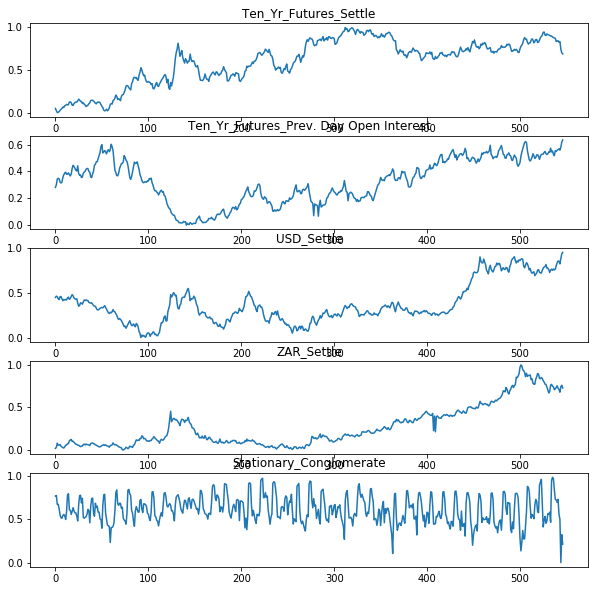

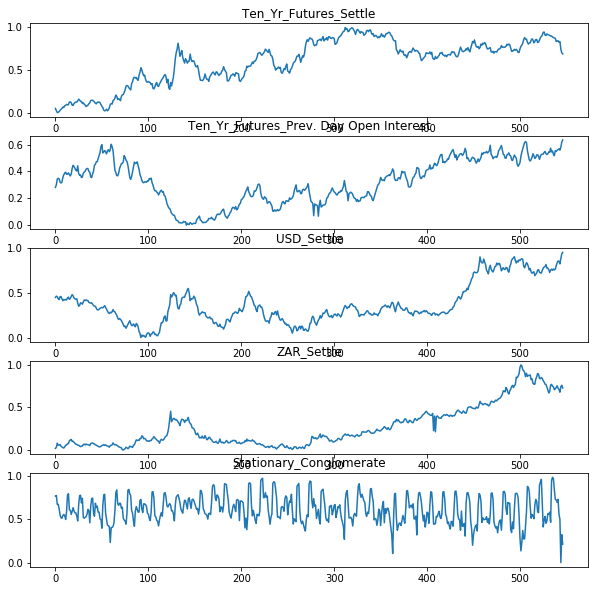

In [74]:
fit_model.plot()

In [273]:
predictions = fit_model.forecast(fit_model.y,steps=len(test.index))
predictions = pd.DataFrame(predictions,index=test.index,columns=test.columns)

In [274]:
for column in predictions.columns:
    print(f"RMSE for {column} is : {sqrt(mean_squared_error(test[column],predictions[column]))}")

RMSE for Ten_Yr_Futures_Settle is : 0.08482243672736843
RMSE for Ten_Yr_Futures_Prev. Day Open Interest is : 0.07589632500977453
RMSE for USD_Settle is : 0.2167752946363747
RMSE for ZAR_Settle is : 0.20802516266733878
RMSE for Stationary_Conglomerate is : 0.2066657578981806


In [ ]:
ax1 = df.

In [ ]:
final_test_stationarity = coint_johansen(df,-1,1)

In [ ]:
sum([1 if final_test_stationarity.lr1[i] >= final_test_stationarity.cvt[i][2] else 0 for i in range(len(df.columns))])

In [ ]:
final_test_stationarity.lr1

In [ ]:
final_test_stationarity.cvt

In [ ]:
final_test_stationarity.eig

In [ ]:
# Need to automate process of conglomerating things for stationarity. Maybe